Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.


Instructions for updating:
non-resource variables are not supported in the long term


Enable just-in-time compilation with XLA.



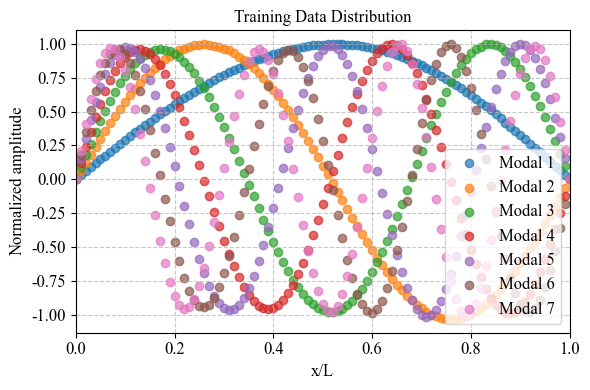

Epoch 1000, Loss: 0.1950
Epoch 2000, Loss: 0.0336
Epoch 3000, Loss: 0.0107
Epoch 4000, Loss: 0.0078
Epoch 5000, Loss: 0.0074
Epoch 6000, Loss: 0.0076
Epoch 7000, Loss: 0.0059
Epoch 8000, Loss: 0.0096
Epoch 9000, Loss: 0.0117
Epoch 10000, Loss: 0.0076
Epoch 11000, Loss: 0.0094
Epoch 12000, Loss: 0.0083
Epoch 13000, Loss: 0.0091
Epoch 14000, Loss: 0.0055
Epoch 15000, Loss: 0.0075
Epoch 16000, Loss: 0.0081
Epoch 17000, Loss: 0.0094
Epoch 18000, Loss: 0.0074
Epoch 19000, Loss: 0.0112
Epoch 20000, Loss: 0.0053
Epoch 21000, Loss: 0.0047
Epoch 22000, Loss: 0.0068
Epoch 23000, Loss: 0.0039
Epoch 24000, Loss: 0.0084
Epoch 25000, Loss: 0.0094
Epoch 26000, Loss: 0.0048
Epoch 27000, Loss: 0.0031
Epoch 28000, Loss: 0.0085
Epoch 29000, Loss: 0.0051
Epoch 30000, Loss: 0.0060
Epoch 31000, Loss: 0.0046
Epoch 32000, Loss: 0.0048
Epoch 33000, Loss: 0.0074
Epoch 34000, Loss: 0.0077
Epoch 35000, Loss: 0.0052
Epoch 36000, Loss: 0.0070
Epoch 37000, Loss: 0.0047
Epoch 38000, Loss: 0.0063
Epoch 39000, Loss: 0.

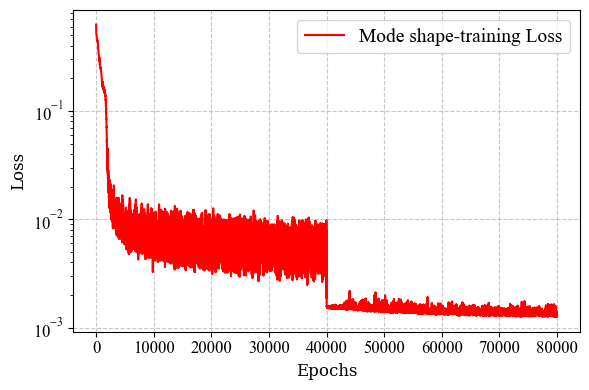

C:\Users\PS\anaconda3\envs\deepxde\lib\site-packages\keras\engine\training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


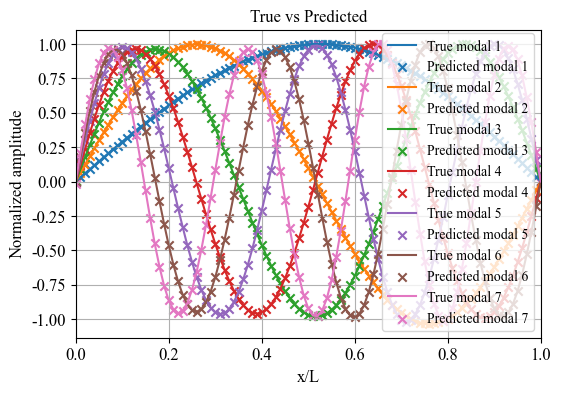

In [5]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import savefig
from sympy import integrate, exp, sin, log, oo, pi,symbols
import deepxde as dde
import scipy.io as scio
from mpl_toolkits.mplot3d import Axes3D
from deepxde.backend import tf
import datetime
import os
from pylab import mpl
from scipy.signal import chirp, spectrogram
mpl.rcParams['font.sans-serif']=['SimHei']
mpl.rcParams['axes.unicode_minus']=False
from matplotlib.pyplot import MultipleLocator
import re
from scipy.io import loadmat
from sklearn.preprocessing import MinMaxScaler
from math import sqrt, pi

from tensorflow.keras.utils import get_custom_objects
from tensorflow.keras.layers import Activation
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import LambdaCallback


def sin_activation(x):
    return tf.math.sin(x)
get_custom_objects().update({'sin': Activation(sin_activation)})


data_pre = np.loadtxt('modal shape.txt')  
X_pre = data_pre[:, 0].reshape(-1, 1)  
y_pre = data_pre[:, 1:8]               

y_pre = y_pre / np.max(y_pre, axis=0)
font = {'family': 'Times New Roman', 'color': 'black', 'weight': 'normal', 'size': 12}


plt.figure(figsize=(6,4))
for i in range(y_pre.shape[1]):
    plt.scatter(X_pre, y_pre[:, i], label=f'Modal {i+1}', alpha=0.7)

plt.title("Training Data Distribution",fontdict=font)
plt.xlabel("x/L",fontdict=font)
plt.ylabel("Normalized amplitude",fontdict=font)
plt.xlim([0,1])
plt.legend(loc='lower right', fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tight_layout()
plt.grid(True, linestyle='--', alpha=0.7)  
plt.savefig('modal_train data.png', dpi=300) 
plt.show()

def create_model():
    model = Sequential()
    model.add(Dense(64, input_dim=1, activation='sin')) 
    model.add(Dense(128, activation='sin')) 
    model.add(Dense(64, activation='sin'))  
    model.add(Dense(7))  #
    return model
def scheduler(epoch, lr):
    if epoch <40000:
        return 0.001  
    else:
        return 0.0001 

lr_scheduler = LearningRateScheduler(scheduler)

tf.compat.v1.disable_eager_execution()

pre_model = create_model()
history1 = pre_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='mae',  
    metrics=['accuracy']
)

def on_epoch_end(epoch, logs):
    if (epoch + 1) % 1000 == 0:
        print(f"Epoch {epoch + 1}, Loss: {logs['loss']:.4f}")

print_callback = LambdaCallback(on_epoch_end=on_epoch_end)
history1 = pre_model.fit(
    X_pre, y_pre,
    epochs= 80000, 
    batch_size=512,  
    callbacks=[print_callback, lr_scheduler], 
    verbose=0
)

for layer in pre_model.layers:
    layer.trainable = False

plt.figure(figsize=(6, 4))
plt.rcParams['font.family'] = 'Times New Roman'
plt.plot(history1.history['loss'], label='Mode shape-training Loss', color='red', linestyle='-')
plt.yscale('log')
plt.title('', fontdict={'family': 'serif', 'color': 'black', 'weight': 'normal', 'size': 12})
plt.xlabel('Epochs', fontdict={'family': 'serif', 'color': 'black', 'weight': 'normal', 'size': 12})
plt.ylabel('Loss', fontdict={'family': 'serif', 'color': 'black', 'weight': 'normal', 'size': 12})
plt.legend(fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tight_layout()
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig('modal_train.png', dpi=300)
plt.show()

y_train_pred = pre_model.predict(X_pre)

plt.figure(figsize=(6,4))
plt.rcParams['font.family'] = 'Times New Roman'
for i in range(y_pre.shape[1]):
    plt.plot(X_pre, y_pre[:, i], label=f'True modal {i+1}', alpha=1)  # 用实线绘制真实值
    plt.scatter(X_pre, y_train_pred[:, i], label=f'Predicted modal {i+1}', alpha=1, marker='x')  # 用点绘制预测值
plt.title("True vs Predicted", fontdict=font)
plt.xlabel("x/L", fontdict=font)
plt.ylabel("Normalized amplitude", fontdict=font)
plt.xlim(0, 1)
plt.xticks(fontsize=12)  # 设置x轴刻度字体大小
plt.yticks(fontsize=12)  # 设置y轴刻度字体大小
plt.legend(loc='lower right', fontsize=10)  #
plt.grid(True)
plt.savefig('modal_pre.png', dpi=300)  #
plt.show()

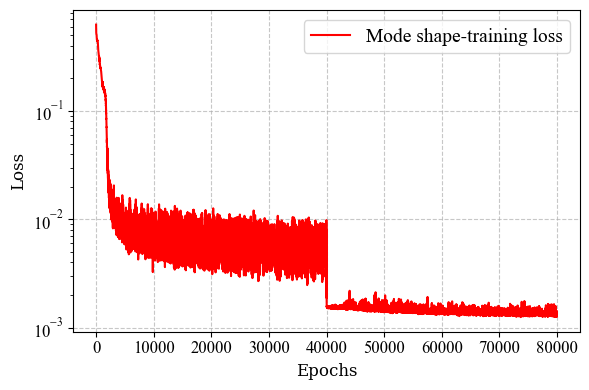

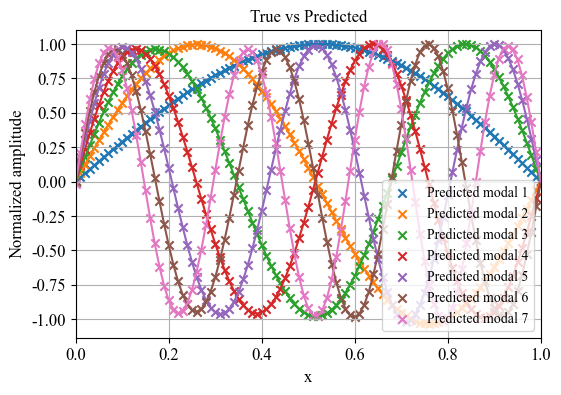

In [6]:
plt.figure(figsize=(6, 4))
plt.rcParams['font.family'] = 'Times New Roman'
plt.plot(history1.history['loss'], label='Mode shape-training loss', color='red', linestyle='-')
plt.yscale('log')
plt.title('', fontdict={'family': 'serif', 'color': 'black', 'weight': 'normal', 'size': 12})
plt.xlabel('Epochs', fontdict={'family': 'serif', 'color': 'black', 'weight': 'normal', 'size': 12})
plt.ylabel('Loss', fontdict={'family': 'serif', 'color': 'black', 'weight': 'normal', 'size': 12})
plt.legend(fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tight_layout()
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig('modal_train.png', dpi=300)
plt.show()
    
y_train_pred = pre_model.predict(X_pre)

plt.figure(figsize=(6,4))
plt.rcParams['font.family'] = 'Times New Roman'
for i in range(y_pre.shape[1]):
    plt.plot(X_pre, y_pre[:, i], label='', alpha=1)  # 用实线绘制真实值
    plt.scatter(X_pre, y_train_pred[:, i], label=f'Predicted modal {i+1}', alpha=1, marker='x')  # 用点绘制预测值
plt.title("True vs Predicted", fontdict=font)
plt.xlabel("x", fontdict=font)
plt.ylabel("Normalized amplitude", fontdict=font)
plt.xlim(0, 1)
plt.xticks(fontsize=12)  # 设置x轴刻度字体大小
plt.yticks(fontsize=12)  # 设置y轴刻度字体大小
plt.legend(loc='lower right', fontsize=10)  #
plt.grid(True)
plt.savefig('modal_pre.png', dpi=300)  #
plt.show()

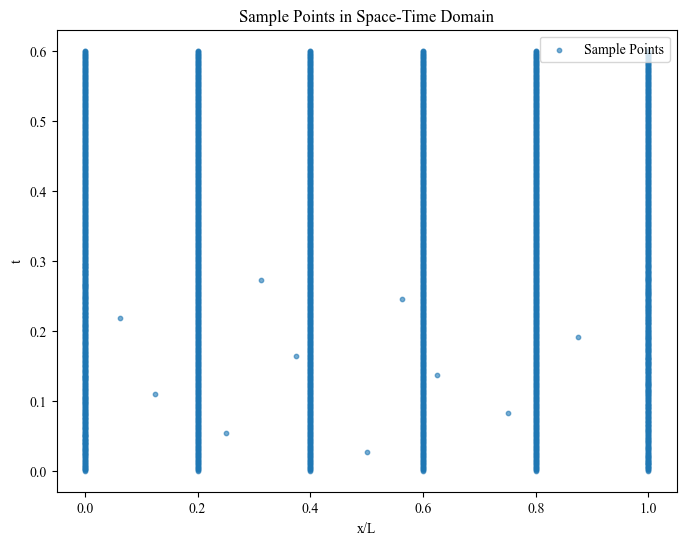

Compiling model...
Building feed-forward neural network...
output shape before return: (None, 1)
'build' took 0.057733 s



C:\Users\PS\anaconda3\envs\deepxde\lib\site-packages\deepxde\nn\tensorflow_compat_v1\fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(
C:\Users\PS\AppData\Local\Temp\ipykernel_23692\4292683588.py:56: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  w = tf.layers.dense(t, w_nodenum, activation_func)
C:\Users\PS\AppData\Local\Temp\ipykernel_23692\4292683588.py:58: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  w = tf.layers.dense(w, w_nodenum, activation_func)
C:\Users\PS\AppData\Local\Temp\ipykernel_23692\4292683588.py:59: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  w = 0.0001*tf.layers.dense(w, 7, None)*X[:,1:2]


'compile' took 0.275900 s

Training model...

Step      Train loss              Test loss               Test metric
0         [0.00e+00, 1.47e+01]    [0.00e+00, 1.47e+01]    []  
1000      [0.00e+00, 5.17e+00]    [0.00e+00, 5.17e+00]    []  
2000      [0.00e+00, 4.36e+00]    [0.00e+00, 4.36e+00]    []  
3000      [0.00e+00, 4.05e+00]    [0.00e+00, 4.05e+00]    []  
4000      [0.00e+00, 3.76e+00]    [0.00e+00, 3.76e+00]    []  
5000      [0.00e+00, 3.53e+00]    [0.00e+00, 3.53e+00]    []  
6000      [0.00e+00, 3.50e+00]    [0.00e+00, 3.50e+00]    []  
7000      [0.00e+00, 3.31e+00]    [0.00e+00, 3.31e+00]    []  
8000      [0.00e+00, 2.80e+00]    [0.00e+00, 2.80e+00]    []  
9000      [0.00e+00, 2.50e+00]    [0.00e+00, 2.50e+00]    []  
10000     [0.00e+00, 2.55e+00]    [0.00e+00, 2.55e+00]    []  
11000     [0.00e+00, 2.56e+00]    [0.00e+00, 2.56e+00]    []  
12000     [0.00e+00, 2.92e+00]    [0.00e+00, 2.92e+00]    []  
13000     [0.00e+00, 2.66e+00]    [0.00e+00, 2.66e+00]    []  
14

In [7]:
def generate_labeled_data():
    data_w = loadmat("beam.mat")
    t_data = data_w["t"].flatten()[:, None] 
    x_data = data_w["x"].flatten()  
    y_data = data_w["Y"]  
    valid_indices = (t_data >= 0) & (t_data <= 0.6)
    t_data_filtered = t_data[valid_indices]
    y_data_filtered = y_data[valid_indices.flatten(), :] 
    num_space_points = 6
    space_indices = np.linspace(0, len(x_data) - 1, num_space_points, dtype=int)  
    x_data_filtered = x_data[space_indices] 
    y_data_filtered_space = y_data_filtered[:, space_indices]  
    X, T = np.meshgrid(x_data_filtered, t_data_filtered.flatten())
    inputs = np.hstack([X.flatten()[:, None], T.flatten()[:, None]])
    outputs = y_data_filtered_space.flatten()[:, None]
    sample_ratio = 1
    num_samples = int(sample_ratio * inputs.shape[0])
    indices = np.random.choice(inputs.shape[0], num_samples, replace=False)
    sampled_inputs = inputs[indices]
    sampled_outputs = outputs[indices]
    return sampled_inputs, sampled_outputs
#————————————————————————————————————————————#
xt_data, y_data = generate_labeled_data()
observe_y1 = dde.icbc.PointSetBC(xt_data, y_data, component=0)  
geom = dde.geometry.Interval(0, 1)
timedomain = dde.geometry.TimeDomain(0, 0.3) 
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

def beam(X, Y):  
    a=0.0*Y
    return a
data = dde.data.TimePDE(geomtime,
                        beam, 
                        [observe_y1], 
                        num_domain=10,
                        num_boundary=100)
train_points = data.train_x

plt.figure(figsize=(8, 6))
plt.scatter(train_points[:, 0], train_points[:, 1], s=10, alpha=0.6, label="Sample Points")
plt.xlabel("x/L")
plt.ylabel("t")
plt.title("Sample Points in Space-Time Domain")
plt.legend()
plt.show()

#————————————————————————————————————————————#
net = dde.maps.FNN([2] + [8], None, "Glorot uniform")    
w_nodenum = 128
w_layer = 4
activation_func = "relu"
def modify_output(X, Y):   
    x = X[:,0:1]
    t = X[:,1:2]
    y1 = tf.zeros_like(x)  #
    w = tf.layers.dense(t, w_nodenum, activation_func)
    for i in range(w_layer):
        w = tf.layers.dense(w, w_nodenum, activation_func)
    w = 0.0001*tf.layers.dense(w, 7, None)*X[:,1:2]
    FAI= pre_model(x)
    for i in range(1, 8):
        wi_term = w[:, (i - 1):i]
        FAIi_term=FAI[:, (i - 1):i]
        y1 += wi_term * FAIi_term  
    print(f"output shape before return: {y1.shape}")
    return tf.concat([y1, w], axis=1)     
net.apply_output_transform(modify_output)
model = dde.Model(data, net)
#————————————————————————————————————————————#

epochs=10000
model.compile("adam",
              lr=1e-3,loss=["MAE","MAE"],loss_weights=[0,1e6])
loss_history, train_state = model.train(iterations=4*epochs, 
                                        display_every=1000, 
                                        disregard_previous_best=True)

model.compile("adam",
              lr=1e-4,loss=["MAE","MAE"],loss_weights=[0,1e6])
loss_history, train_state = model.train(iterations=4*epochs, 
                                        display_every=1000, 
                                        disregard_previous_best=True)
model.compile("adam",
              lr=1e-5,loss=["MAE","MAE"],loss_weights=[0,1e6])
loss_history, train_state = model.train(iterations=8*epochs, 
                                        display_every=1000, 
                                        disregard_previous_best=True)



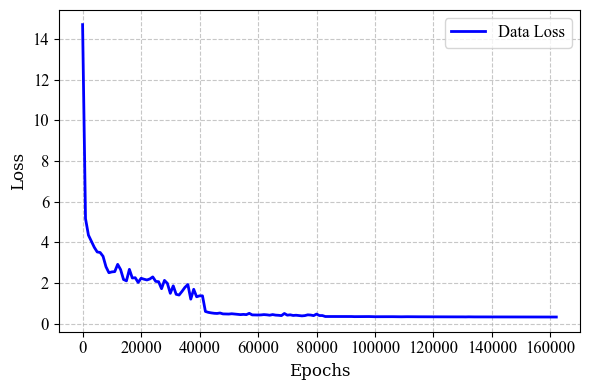

In [8]:

train_loss = loss_history.loss_train

Physics_losses = [loss[0] for loss in train_loss]
Data_losses = [loss[1] for loss in train_loss]


total_losses = [p + d for p, d in zip(Physics_losses, Data_losses)]

epochs = np.arange(len(train_loss)) * 1000  

font = {'family': 'serif', 'color': 'black', 'weight': 'normal', 'size': 12}

plt.figure(figsize=(6, 4))
plt.plot(epochs, Data_losses, label='Data Loss', color='blue', linestyle='-', linewidth=2)  # 点线
plt.title('', fontdict=font)
plt.xlabel('Epochs', fontdict=font)
plt.ylabel('Loss', fontdict=font)
plt.legend(fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tight_layout()
plt.grid(True, linestyle='--', alpha=0.7)  # 更加淡化的网格
plt.savefig("LOSS.png", dpi=300)
plt.show()

C:\Users\PS\AppData\Local\Temp\ipykernel_23692\958134206.py:32: RuntimeWarning: divide by zero encountered in divide
  R_y_error = abs((y_pre_reshaped - y_true_reshaped)/y_true_reshaped)
C:\Users\PS\AppData\Local\Temp\ipykernel_23692\958134206.py:32: RuntimeWarning: invalid value encountered in divide
  R_y_error = abs((y_pre_reshaped - y_true_reshaped)/y_true_reshaped)


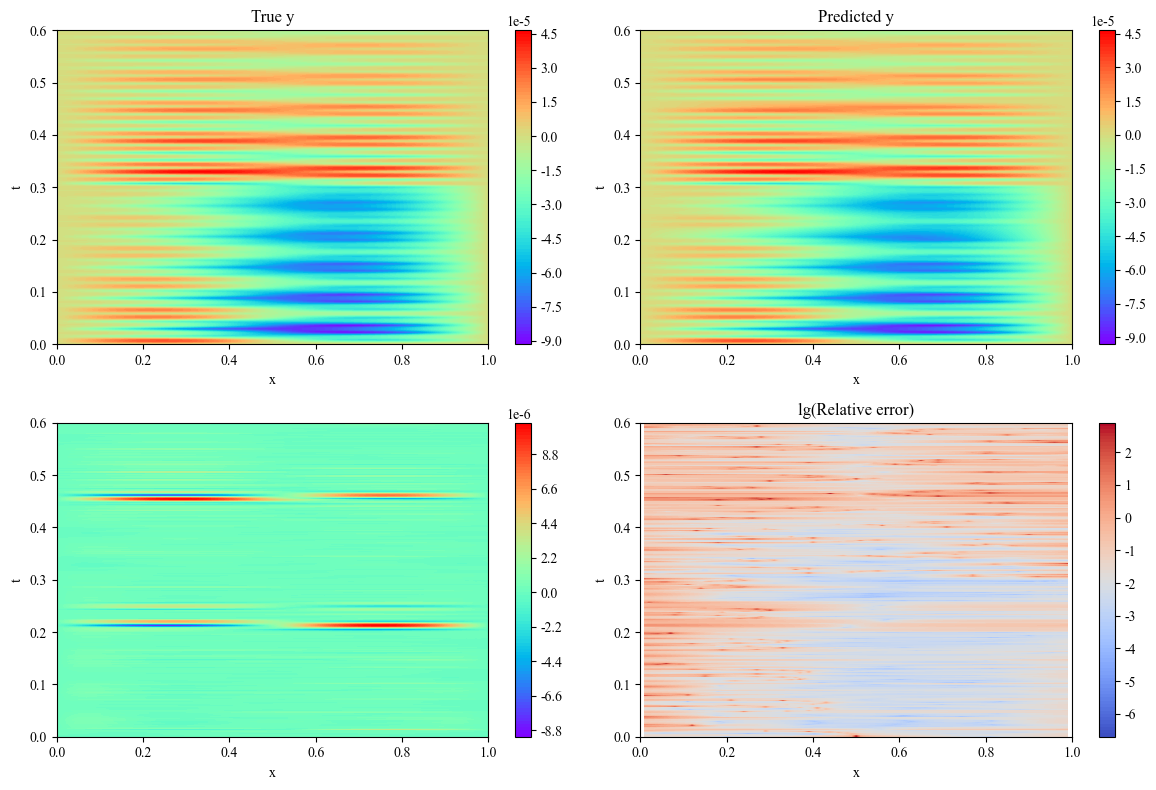

In [9]:
def generate_labeled_data2():
    data_w = loadmat("beam.mat")
    t_data = data_w["t"].flatten()[:, None]  
    x_data = data_w["x"].flatten() 
    y_data = data_w["Y"]
    valid_indices = (t_data >= 0) & (t_data <= 0.6)
    t_data_filtered = t_data[valid_indices]
    y_data_filtered = y_data[valid_indices.flatten(), :] 
    X, T = np.meshgrid(x_data, t_data_filtered.flatten())
    inputs = np.hstack([X.flatten()[:, None], T.flatten()[:, None]])
    outputs = y_data_filtered.flatten()[:, None]
    return inputs, outputs

xt2_data, y2_data = generate_labeled_data2()

predictions = model.predict(xt2_data)
Y_PRE=predictions [:,0:1]
w1=predictions [:,1:2]
w2=predictions [:,2:3]
w3=predictions [:,3:4]
w4=predictions [:,4:5]
w5=predictions [:,5:6]
w6=predictions [:,6:7]
w7=predictions [:,7:8]

X = xt2_data[:, 0].reshape(-1, 101)  
T = xt2_data[:, 1].reshape(-1, 101) 
y_true_reshaped= y2_data.reshape(-1, 101)
y_pre_reshaped = Y_PRE.reshape(-1, 101)

y_error = y_pre_reshaped - y_true_reshaped
R_y_error = abs((y_pre_reshaped - y_true_reshaped)/y_true_reshaped)
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 10 

plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.contourf(X, T, y_true_reshaped, levels=100, cmap='rainbow')
plt.colorbar(label='')
plt.xlabel('x')
plt.ylabel('t')
plt.title('True y')

plt.subplot(2, 2, 2)
plt.contourf(X, T, y_pre_reshaped, levels=100, cmap='rainbow')
plt.colorbar(label='')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Predicted y')

plt.subplot(2, 2, 3)
plt.contourf(X, T, y_error, levels=100, cmap='rainbow')
plt.colorbar(label='')
plt.xlabel('x')
plt.ylabel('t')
plt.title('')

log_R_y_error = np.log10(R_y_error) 
plt.subplot(2, 2, 4)
plt.contourf(X, T, log_R_y_error, levels=100, cmap='coolwarm')
plt.colorbar(label='')
plt.xlabel('x')
plt.ylabel('t')
plt.title('lg(Relative error)')
plt.tight_layout()
plt.savefig("2.png", dpi=300)
plt.show()


Pearson correlation coefficient: 0.998853299615281


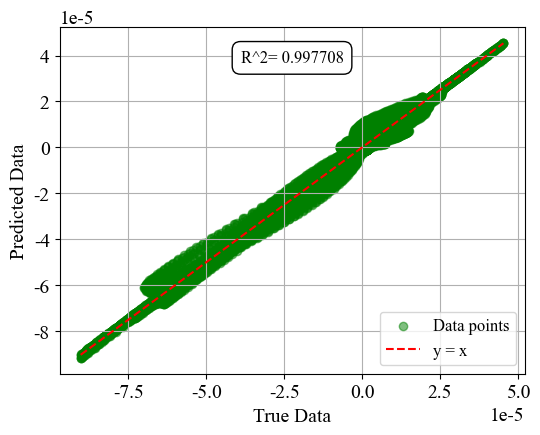

In [10]:
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 14  
plt.figure(figsize=(6, 4.5))

plt.scatter(y2_data, Y_PRE, color="green", alpha=0.5, label="Data points")
y2_data = y2_data.flatten()
Y_PRE = Y_PRE.flatten()

correlation, _ = pearsonr(y2_data, Y_PRE)
print(f"Pearson correlation coefficient: {correlation}")
r_squared = correlation ** 2


plt.text(0.5, 0.9, f"R^2= {r_squared:.6f}", fontsize=12, ha='center', 
         transform=plt.gca().transAxes,
         bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))

plt.plot([min(y2_data), max(y2_data)], [min(y2_data), max(y2_data)], color="red", linestyle="--", label="y = x")

plt.xlabel("True Data")
plt.ylabel("Predicted Data")
plt.title("")
plt.xticks(fontsize=14) 
plt.yticks(fontsize=14)  
plt.legend(loc='lower right', fontsize=12)  
plt.grid()
plt.savefig("4.png", dpi=300)

C:\Users\PS\AppData\Local\Temp\ipykernel_23692\2281285166.py:18: RuntimeWarning: invalid value encountered in divide
  relative_error_1_4 = np.abs(y_true_1_4 - y_pred_1_4) / np.abs(y_true_1_4)
C:\Users\PS\AppData\Local\Temp\ipykernel_23692\2281285166.py:19: RuntimeWarning: invalid value encountered in divide
  relative_error_1_2 = np.abs(y_true_1_2 - y_pred_1_2) / np.abs(y_true_1_2)
C:\Users\PS\AppData\Local\Temp\ipykernel_23692\2281285166.py:20: RuntimeWarning: invalid value encountered in divide
  relative_error_3_4 = np.abs(y_true_3_4 - y_pred_3_4) / np.abs(y_true_3_4)


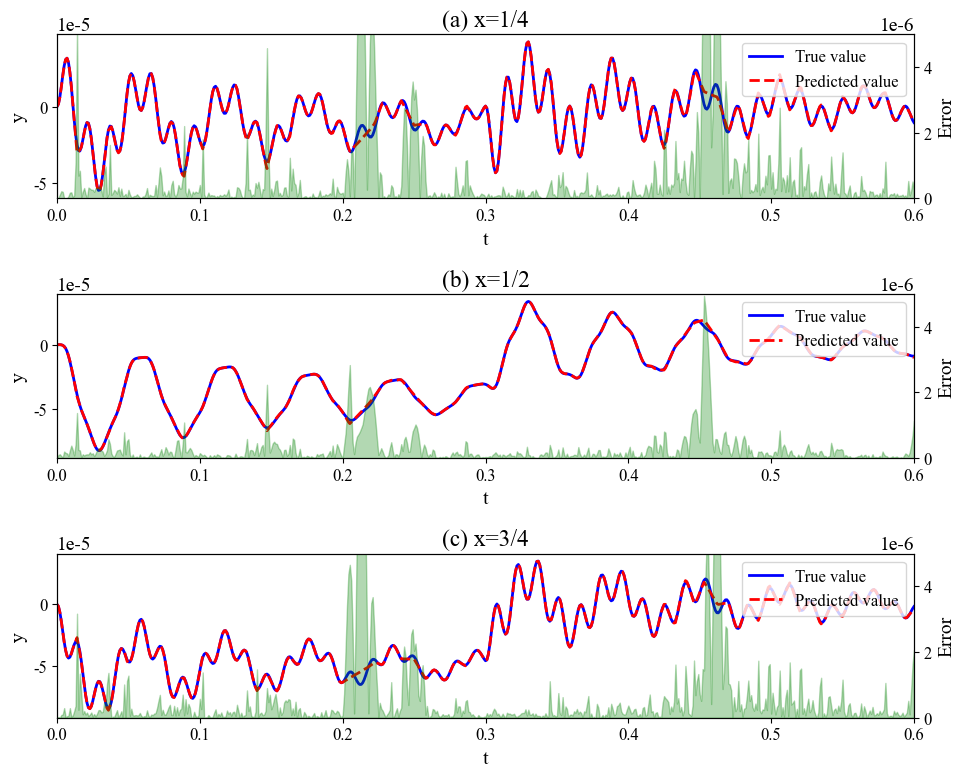

In [11]:
x_indices = [25, 50, 75] 

t_data = xt2_data[:, 1].reshape(-1, 101)  

y_true_reshaped= y2_data.reshape(-1, 101)

y_pre_reshaped = Y_PRE.reshape(-1, 101)

y_true_1_4 = y_true_reshaped[:, 25:26]
y_true_1_2 = y_true_reshaped[:, 50:51]
y_true_3_4 = y_true_reshaped[:, 75:76]


y_pred_1_4 = y_pre_reshaped[:, 25:26]
y_pred_1_2 = y_pre_reshaped[:, 50:51]
y_pred_3_4 = y_pre_reshaped[:, 75:76]

relative_error_1_4 = np.abs(y_true_1_4 - y_pred_1_4) / np.abs(y_true_1_4)
relative_error_1_2 = np.abs(y_true_1_2 - y_pred_1_2) / np.abs(y_true_1_2)
relative_error_3_4 = np.abs(y_true_3_4 - y_pred_3_4) / np.abs(y_true_3_4)
Error_1_4 = np.abs(y_true_1_4 - y_pred_1_4) 
Error_1_2 = np.abs(y_true_1_2 - y_pred_1_2)
Error_3_4 = np.abs(y_true_3_4 - y_pred_3_4)



plt.figure(figsize=(10, 8))
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 14  

epsilon = 1e-10

plt.subplot(3, 1, 1)
ax1 = plt.gca()  
ax2 = ax1.twinx() 

ax1.plot(t_data[:, 0], y_true_1_4, label='True value', color='blue', linestyle='-', linewidth=2)
ax1.plot(t_data[:, 0], y_pred_1_4, label='Predicted value', color='red', linestyle='--', linewidth=2)


ax2.fill_between(t_data[:, 0], 0, Error_1_4.flatten(), color='green', alpha=0.3)

ax1.set_xlabel('t')
ax1.set_ylabel('y')
ax2.set_ylabel('Error')
ax1.set_xlim(0, 0.6)
ax2.set_ylim(0, 5e-6)

ax1.tick_params(axis='x', labelsize=12)
ax1.tick_params(axis='y', labelsize=12)
ax2.tick_params(axis='y', labelsize=12)

ax1.set_title('(a) x=1/4')
ax1.legend(loc='upper right', fontsize=12)

plt.subplot(3, 1, 2)
ax1 = plt.gca()  
ax2 = ax1.twinx() 

ax1.plot(t_data[:, 0], y_true_1_2, label='True value', color='blue', linestyle='-', linewidth=2)
ax1.plot(t_data[:, 0], y_pred_1_2, label='Predicted value', color='red', linestyle='--', linewidth=2)


log_relative_error_1_2 = np.log(np.abs(relative_error_1_2.flatten()) + epsilon)
ax2.fill_between(t_data[:, 0], 0, Error_1_2.flatten(), color='green', alpha=0.3)
ax1.set_xlabel('t')
ax1.set_ylabel('y')
ax2.set_ylabel('Error')
ax1.set_xlim(0, 0.6)
ax2.set_ylim(0, 5e-6)
ax1.tick_params(axis='x', labelsize=12)
ax1.tick_params(axis='y', labelsize=12)
ax2.tick_params(axis='y', labelsize=12)

ax1.set_title('(b) x=1/2')
ax1.legend(loc='upper right', fontsize=12)

plt.subplot(3, 1, 3)
ax1 = plt.gca()  
ax2 = ax1.twinx()  

ax1.plot(t_data[:, 0], y_true_3_4, label='True value', color='blue', linestyle='-', linewidth=2)
ax1.plot(t_data[:, 0], y_pred_3_4, label='Predicted value', color='red', linestyle='--', linewidth=2)


log_relative_error_3_4 = np.log(np.abs(relative_error_3_4.flatten()) + epsilon)

ax2.fill_between(t_data[:, 0], 0, Error_3_4.flatten(), color='green', alpha=0.3)

ax1.set_xlabel('t')
ax1.set_ylabel('y')
ax2.set_ylabel('Error')
ax1.set_xlim(0, 0.6)
ax2.set_ylim(0, 5e-6)

ax1.tick_params(axis='x', labelsize=12)
ax1.tick_params(axis='y', labelsize=12)
ax2.tick_params(axis='y', labelsize=12)

ax1.set_title('(c) x=3/4')
ax1.legend(loc='upper right', fontsize=12)

plt.tight_layout()
plt.savefig("6.png", dpi=300)
plt.show()
